# Investigating the behaviour of scalar fields in finite dimensional Hilbert spaces
## Table of contents:

- Section 1: approximations to the results of Singh & Carroll (2018)
- Section 2: Scaling of number of degrees of freedom with size of Universe
- Section 3: Dynamical vacuum energy from Hilbert space finite dimensionality

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import mpmath
from scipy.optimize import minimize
import time

In [2]:
# Defining a number of constants
L_Planck_in_SI = 1.616255e-35
E_Planck_in_SI = 1.956e9
E_Planck_in_eV = 1.2209e28
R_hubble_prefactor = 2.9979*3.0857*1.0e25/L_Planck_in_SI
h = 0.7
R_Hubble_in_Planck = R_hubble_prefactor/h
L_c = 4.4963302789e+00*R_Hubble_in_Planck # particle horizon at a->infty for (Omega_m = 0.286, h = 0.7)
kUV = 1.0 # Using M_Planck as UV cut off
dmin = 2.0 # minimum mode dimension

# floating point precition of mpmath module
mpmath.mp.dps = 25

# Section 1: approximations to the results of Singh & Carroll (2018)

In [3]:
def csc(theta):
    return 1.0/np.sin(theta)

# This function returns the Hamiltonian of a finite dimensional harmonic oscillator,
# as derived in Singh & Carroll (2018), https://arxiv.org/pdf/1806.10134.pdf
#

def return_Hamiltonian(Omega_p, Omega_q, alpha, l_max):
    N = 2*l_max + 1
    H = np.zeros((N,N))
    #
    # pre-calculating factors to simplify the subsequent computations:
    prefactor_1 = 2.0*np.pi*l_max/(2.0*l_max+1)
    prefactor_2 = Omega_p*(np.pi/N/alpha)**2
    prefactor_3 = alpha**2*Omega_q
    #
    # The indices of the Hamitonian matrix range from -l to l
    # (cf. Singh & Carroll)
    x = np.arange(-l_max,l_max+0.5, 1.0).astype('int')
    y1 = 0.0*x
    y2 = 0.0*x
    #
    # calculating the term in the Hamiltonian that is proportional
    # to the position operator:
    for j in range(-l_max,l_max+1):
        H[j+l_max,j+l_max] = prefactor_3*j**2
    #
    # calculating the term in the Hamiltonian that is proportional
    # to the momentum operator:
    for j1 in range(-l_max,l_max+1):
        indxs = np.where(x != j1)[0]
        y1[indxs] = csc(prefactor_1*(j1-x[indxs]))
        y1[j1+l_max] = 0.0
        for j2 in range(j1,l_max+1):
            indxs = np.where(x != j2)[0]
            y2[indxs] = csc(prefactor_1*(j2-x[indxs]))
            y2[j2+l_max] = 0.0
            H[j1+l_max,j2+l_max] += np.sum(y1*y2)*prefactor_2
    H += np.transpose(H)
    for j in range(-l_max,l_max+1):
        H[j,j] /= 2.0
    return H


def return_O_X(X, l_max):
    N = 2*l_max + 1
    O_X = np.zeros((N,N))
    #
    # pre-calculating factors to simplify the subsequent computations:
    prefactor_1 = 2.0*np.pi*l_max/(2.0*l_max+1)
    #
    # The indices of the Hamitonian matrix range from -l to l
    # (cf. Singh & Carroll)
    x = np.arange(-l_max,l_max+0.5, 1.0).astype('int')
    y1 = 0.0*x
    y2 = 0.0*x
    #
    # calculating the term in the Hamiltonian that is proportional
    # to the position operator:
    for j in range(-l_max,l_max+1):
        O_X[j+l_max,j+l_max] = X*j**2
    #
    # calculating the term in the Hamiltonian that is proportional
    # to the momentum operator:
    for j1 in range(-l_max,l_max+1):
        indxs = np.where(x != j1)[0]
        y1[indxs] = csc(prefactor_1*(j1-x[indxs]))
        y1[j1+l_max] = 0.0
        for j2 in range(j1,l_max+1):
            indxs = np.where(x != j2)[0]
            y2[indxs] = csc(prefactor_1*(j2-x[indxs]))
            y2[j2+l_max] = 0.0
            O_X[j1+l_max,j2+l_max] += np.sum(y1*y2)/4.0
    O_X += np.transpose(O_X)
    for j in range(-l_max,l_max+1):
        O_X[j,j] /= 2.0
    return O_X

# Computing the minimum eigenvalue of the Hamiltonian
#
def return_lambda_min(Omega_p, Omega_q, alpha, l_max):
    H = np.matrix(return_Hamiltonian(Omega_p, Omega_q, alpha, l_max))
    evs = scipy.linalg.eigh(H)[0]
    return np.min(evs)

def return_lambda_O_X(X, l_max):
    O_X = np.matrix(return_O_X(X, l_max))
    evs = scipy.linalg.eigh(O_X)[0]
    return np.min(evs)


In [4]:
# calculating data to reproduce the upper panel in figure 6
# of Friedrich, Singh, Dore (2022)

l_max = 4
X_min = 0.00001
X_max = 100000.0
N_X = 151
x_X = (X_max/X_min)**(1.0/(N_X-1))
X_values = np.zeros(N_X)
lambda_min_values = X_values*0.0
#
for i in range(0, len(X_values)):
    X_values[i] = X_min*x_X**i
    lambda_min_values[i] = return_lambda_O_X(X_values[i], l_max)
    print("\rcalculating minimal eigenvalues of \hat O_X at X = ", X_values[i], end="")
    time.sleep(0.01)

print("\rCalculation of minimal eigenvalues of \hat O_X done.                                          ")

def max_rel_error(x, d):
    A = (np.pi*d/6.0)**x - 2
    return np.max(np.abs((d**2/12./(1.0/(X_values)**x + A/(X_values**0.5)**x + 1.0)**(1./x)-lambda_min_values)/lambda_min_values))

print("Maximum relative error for dim >= 9:", max_rel_error(3.0, 9))

Calculation of minimal eigenvalues of \hat O_X done.                                          
Maximum relative error for dim >= 9: 0.030065747006205623


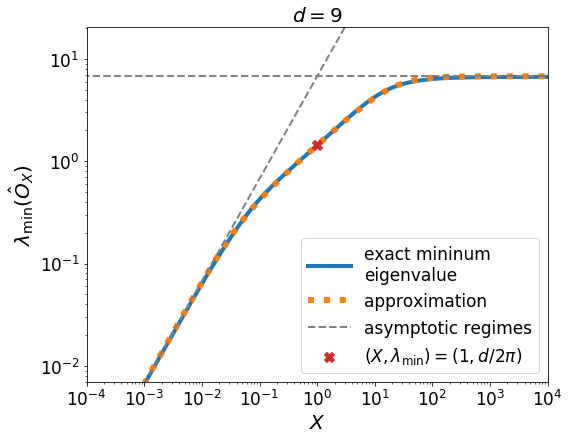

In [5]:
# reproducing the upper panel in figure 6
# of Friedrich, Singh, Dore (2022)

plt.figure(figsize=(8,6))
d = 2.0*l_max + 1.0
x = 3.0
A = (np.pi*d/6.0)**x - 2
plt.loglog(X_values, lambda_min_values, linestyle='solid', color='tab:blue', linewidth=4, label='exact mininum\neigenvalue')
plt.loglog(X_values, d**2/12./(1.0/(X_values)**x + A/(X_values**0.5)**x + 1.0)**(1./x), linestyle='dotted', color='tab:orange', linewidth=6, label='approximation')
plt.loglog(X_values, 0.0*X_values + d**2/12., linestyle='dashed', color='grey', linewidth=2, label='asymptotic regimes')
plt.loglog(X_values, X_values*d**2/12., linestyle='dashed', color='grey', linewidth=2)
plt.scatter([1.0],[d/(2.0*np.pi)] , color='tab:red', marker='X', s=100, zorder=5, label=r'$(X, \lambda_{\min}) = (1, d/2\pi)$')
plt.xlim(0.0001, 10000.0)
plt.ylim(0.007, 3.0*d**2/12.)


plt.legend(fontsize=17, handlelength=2.5)
plt.xticks(size=17)
plt.yticks(size=17)
plt.xlabel(r"$X$", size=20)
plt.ylabel(r"$\lambda_{\min}(\hat O_X)$", size=20)
plt.title(r"$d = $"+str(2*l_max+1), size=20)
plt.subplots_adjust(left=0.15, bottom=0.11, top=0.93, right=0.95)
plt.savefig("min_eigenvalue_O_X.pdf")




In [6]:
# calculating data to reproduce the lower panel in Figure 6
# of Friedrich, Singh, Dore (2022)

M = 2
Omega = 30
Omega_q = M*Omega**2/2.0
Omega_p = 1.0/(2.0*M)
l_values = np.arange(1,150,1).astype('int')
d_values = 2*l_values+1
alpha_0_values = np.sqrt(2.0*np.pi/d_values)
A_1 = 0.05*M*Omega
A_2 = 0.01*M*Omega
E_min_values_1 = l_values*0.0
E_min_values_2 = l_values*0.0
E_min_approx_1 = l_values*0.0
E_min_approx_2 = l_values*0.0
#
for i in range(0, len(l_values)):
    #print(i)
    E_min_values_1[i] = return_lambda_min(Omega_p, Omega_q, alpha_0_values[i]/np.sqrt(A_1), l_values[i])
    E_min_values_2[i] = return_lambda_min(Omega_p, Omega_q, alpha_0_values[i]/np.sqrt(A_2), l_values[i])
    E_min_approx_1[i] = Omega/2.0*mpmath.erf(np.pi**1.5*A_1*d_values[i]/(12*M*Omega))
    E_min_approx_2[i] = Omega/2.0*mpmath.erf(np.pi**1.5*A_2*d_values[i]/(12*M*Omega))
    print("\rcalculating minimal eigenvalues of \hat H at dim = ", d_values[i], end="")

print("\rCalculation of minimal eigenvalues of \hat H done                           ")
i_min = 2
print("Maximum relative error for dim >=", d_values[i_min], " and M*Omega/A = 20:", np.max(np.abs((E_min_values_1[i_min:]-E_min_approx_1[i_min:])/E_min_values_1[i_min:])))
print("Maximum relative error for dim >=", d_values[i_min], " and M*Omega/A = 100:", np.max(np.abs((E_min_values_2[i_min:]-E_min_approx_2[i_min:])/E_min_values_2[i_min:])))

Calculation of minimal eigenvalues of \hat H done                           
Maximum relative error for dim >= 7  and M*Omega/A = 20: 0.019294382356286645
Maximum relative error for dim >= 7  and M*Omega/A = 100: 0.020770058488054938


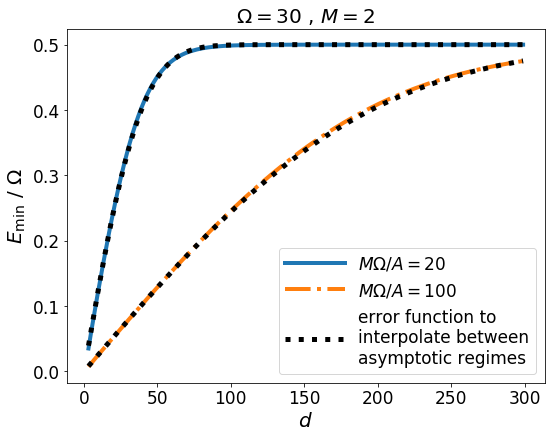

In [7]:
# reproducing the lower panel in Figure 6
# of Friedrich, Singh, Dore (2022)

plt.figure(figsize=(8,6))
plt.plot(d_values, E_min_values_1/Omega, linestyle='solid', color='tab:blue', linewidth=4, label=r'$M\Omega/A = 20$')
plt.plot(d_values, E_min_approx_1/Omega, linestyle='dotted', color='black', linewidth=5)
plt.plot(d_values, E_min_values_2/Omega, linestyle='-.', color='tab:orange', linewidth=4, label=r'$M\Omega/A = 100$')
plt.plot(d_values, E_min_approx_2/Omega, linestyle='dotted', color='black', linewidth=5, label='error function to\ninterpolate between\nasymptotic regimes')


plt.legend(fontsize=17, handlelength=3.5)
plt.xticks(size=17)
plt.yticks(size=17)
plt.xlabel(r"$d$", size=20)
plt.ylabel(r"$E_{\min}\ /\ \Omega$", size=20)
plt.title(r"$\Omega = $"+str(Omega)+r" , $M = $"+str(M), size=20)
plt.subplots_adjust(left=0.1, bottom=0.1, top=0.94, right=0.95)
plt.subplots_adjust(left=0.12, bottom=0.11, top=0.93, right=0.95)
plt.savefig("E_min_approx.pdf")



# Section 2: Scaling of number of degrees of freedom with size of Universe

In [8]:
# calculating data to reproduce Figure 1
# of Friedrich, Singh, Dore (2022)

N_param = 37

n_min = 0.5
n_max = -9.5
dn = (n_max-n_min)/(N_param-1)

logD_min = -6.0
logD_max = 3.0
dlogD = (logD_max-logD_min)/(N_param-1)

n_values = np.arange(n_min, n_max + 0.5*dn, dn)
logD_values = np.arange(logD_min, logD_max + 0.5*dlogD, dlogD)

gamma_values_1 = np.zeros((N_param, N_param))
N_qubit_1 = np.zeros((N_param, N_param))
gamma_values_08 = np.zeros((N_param, N_param))
N_qubit_08 = np.zeros((N_param, N_param))
gamma_values_05 = np.zeros((N_param, N_param))
N_qubit_05 = np.zeros((N_param, N_param))

for j in range(0, N_param):
    n_D = n_values[j]
    print("\rcomputing row", j+1, "of", str(N_param), end="")
    for i in range(0, N_param):
        logD = logD_values[i]
        D = mpmath.exp(logD)
        k_min = 1.0/L_c
        def integrand_gamma(lnk):
            k = mpmath.exp(lnk)
            return k**3*mpmath.log(D*(k/kUV)**n_D + dmin, 2)
        scale = 1.0
        k_max = scale*kUV
        N_qubit_1[i,j] = mpmath.quad(integrand_gamma, [mpmath.ln(k_min), mpmath.ln(k_max)])
        gamma_values_1[i,j] = k_max**3*mpmath.log(D*scale**n_D + dmin, 2)/N_qubit_1[i,j]
        scale = 0.8
        k_max = scale*kUV
        N_qubit_08[i,j] = mpmath.quad(integrand_gamma, [mpmath.ln(k_min), mpmath.ln(k_max)])
        gamma_values_08[i,j] = k_max**3*mpmath.log(D*scale**n_D + dmin, 2)/N_qubit_08[i,j]
        scale = 0.5
        k_max = scale*kUV
        N_qubit_05[i,j] = mpmath.quad(integrand_gamma, [mpmath.ln(k_min), mpmath.ln(k_max)])
        gamma_values_05[i,j] = k_max**3*mpmath.log(D*scale**n_D + dmin, 2)/N_qubit_05[i,j]

print("\rComputation done                           ")

N_qubit_1  *= L_c**3/2.0/np.pi**2
N_qubit_08 *= L_c**3/2.0/np.pi**2
N_qubit_05 *= L_c**3/2.0/np.pi**2


Computation done                           


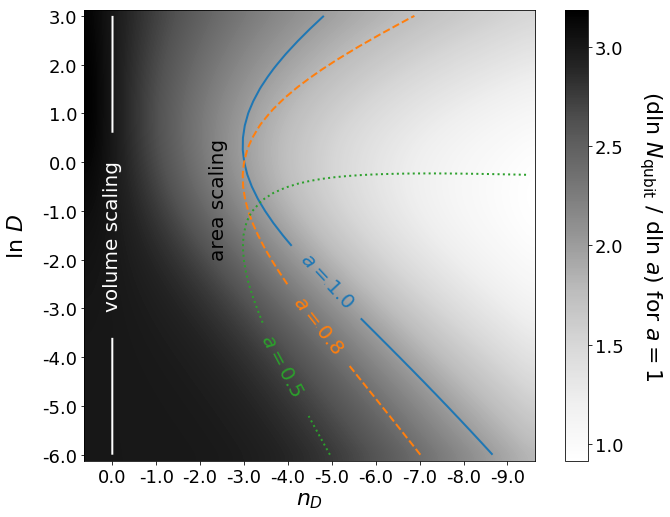

In [9]:
# reproducing Figure 1 of
# Friedrich, Singh, Dore (2022)

plt.figure(figsize=(10,7.2))

plt.imshow(gamma_values_1, interpolation='bicubic', cmap='Greys')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'$(\mathrm{d}\ln\ N_{\mathrm{qubit}}\ /\ \mathrm{d}\ln\ a)$ for $a=1$', size=22, rotation=270, labelpad=40)
cons = plt.contour(gamma_values_1, colors='white', linewidths=2, levels=[3.0])
fmt = {}
strs = ['volume scaling']
for l, s in zip(cons.levels, strs):
    fmt[l] = s
plt.clabel(cons, fmt=fmt, fontsize=20, use_clabeltext=True)
cons_1 = plt.contour(gamma_values_1, colors='tab:blue', linewidths=2, linestyles='solid', levels=[2.0])
cons_08 = plt.contour(gamma_values_08, colors='tab:orange', linewidths=2, linestyles='dashed', levels=[2.0])
cons_05 = plt.contour(gamma_values_05, colors='tab:green', linewidths=2, linestyles='dotted', levels=[2.0])
plt.clabel(cons_1, fmt=fmt, fontsize=0, use_clabeltext=True, inline_spacing = 45, manual = [(20,15)])
plt.clabel(cons_08, fmt=fmt, fontsize=0, use_clabeltext=True, inline_spacing = 45, manual = [(19,11)])
plt.clabel(cons_05, fmt=fmt, fontsize=0, use_clabeltext=True, inline_spacing = 45, manual = [(16,7)])
plt.text(19.4,14.3, "$a = 1.0$", rotation=-47, color='tab:blue', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.text(18.7,10.65, "$a = 0.8$", rotation=-52, color='tab:orange', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.text(15.7,7.4, "$a = 0.5$", rotation=-62, color='tab:green', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.text(10.5,21, "area scaling", rotation=90, color='black', horizontalalignment='center', verticalalignment='center', fontsize=20)


ax = plt.gca()
ax.set_ylim(N_param-0.5, -0.5)
ax.set_xlim(-0.5, N_param-0.5)
ax.invert_yaxis()

indxs = np.arange(0, N_param-0.5, 1)
xvals = np.arange(-9.0, 0.1, 1.0)
yvals = np.arange(-6.0, 3.1, 1.0)
xts = np.interp(-xvals, -n_values, indxs)
yts = np.interp(yvals, logD_values, indxs)
ax.set_xticks(xts, minor=False)
ax.set_yticks(yts, minor=False)
x_strings = ["%.1f" % x for x in xvals]
y_strings = ["%.1f" % y for y in yvals]
ax.set_xticklabels(x_strings, size=18)
ax.set_yticklabels(y_strings, size=18)

plt.ylabel(r'$\ln\ D$', size=22, labelpad = 15)
plt.xlabel(r'$n_D$', size=22)


plt.subplots_adjust(left = 0.10, bottom=0.10, top=0.97, right=0.93)
plt.savefig("gamma_as_function_of_dimensionality.pdf")

# Section 3: Dynamical vacuum energy from Hilbert space finite dimensionality

In [10]:

# This function is calculating the vacuum energy density and
# its derivatives wrt. the radius of the observable Universe
# in the fiducial scenario of Friedrich, Singh, Dore (2022).
# 
# Arguments:
#     L_ph == radius of the observable Universe
# (D, n_D) == dimensionality parameters (cf. equation 2.32)
#
def return_vacuum_energy_density_and_derivatives(scale_factor, D, n_D):
    L_ph = scale_factor*L_c
    A = mpmath.pi**1.5/12.0/kUV**2
    X = 1.0/(2.0*np.pi)**2
    Y = n_D/L_ph*2.0/np.sqrt(np.pi)/(2.0*np.pi)**2
    dmin = 2.0
    k_min = 1.0/L_ph
    logk_min = mpmath.log(k_min)
    k_max = kUV
    logk_max = mpmath.log(k_max)
    #
    def f_eps(lnk):
        k = mpmath.exp(lnk)
        Ak = A*k**2
        Ck = Ak*dmin
        Ak = Ak*D*(scale_factor*k/kUV)**n_D
        Ck = Ck + Ak
        k4 = k**4
        return k4*mpmath.erf(Ck)
    #
    def f_eps_prime(lnk):
        k = mpmath.exp(lnk)
        Ak = A*k**2
        Ck = Ak*dmin
        Ak = Ak*D*(scale_factor*k/kUV)**n_D
        Ck = Ck + Ak
        k4 = k**4
        return k4*Ak*mpmath.exp(-Ck**2)
    #
    def f_eps_prime_prime(lnk):
        k = mpmath.exp(lnk)
        Ak = A*k**2
        Ck = Ak*dmin
        Ak = Ak*D*(scale_factor*k/kUV)**n_D
        Ck = Ck + Ak
        k4 = k**4
        return k4*Ak*mpmath.exp(-Ck**2)*(1.0-2.0*Ck*Ak)
    #
    integral_eps = mpmath.quad(f_eps, [logk_min, logk_max])
    integral_eps *= X
    #
    integral_deps_dR = mpmath.quad(f_eps_prime, [logk_min, logk_max])
    integral_deps_dR *= Y
    #
    integral_d2eps_dR2 = mpmath.quad(f_eps_prime_prime, [logk_min, logk_max])
    integral_d2eps_dR2 *= n_D*Y
    integral_d2eps_dR2 -= integral_deps_dR
    integral_d2eps_dR2 /= L_ph
    #
    return integral_eps, integral_deps_dR, integral_d2eps_dR2


# This uses equation 4.3 of Friedrich, Singh, Dore (2022) to calculate the
# equation of state parameters of vacuum energy density:
#
def return_w(scale_factor, D, n_D):
    L_ph = scale_factor*L_c
    eps, deps_dR, d2eps_dR2 = return_vacuum_energy_density_and_derivatives(scale_factor, D, n_D)
    w0 = -(1.0+deps_dR*L_ph/eps/3.0)
    wa = L_ph/(3.0*eps)*(deps_dR - L_ph*deps_dR**2/eps + L_ph*d2eps_dR2)
    return eps, w0, wa


In [11]:
# calculating data to reproduce Figure 2
# of Friedrich, Singh, Dore (2022)

N_param = 37

n_min = 0.5
n_max = -9.5
dn = (n_max-n_min)/(N_param-1)

logD_min = -6.0
logD_max = 3.0
dlogD = (logD_max-logD_min)/(N_param-1)

n_values = np.arange(n_min, n_max + 0.5*dn, dn)
logD_values = np.arange(logD_min, logD_max + 0.5*dlogD, dlogD)

eps_values = np.zeros((N_param, N_param))
w_values = np.zeros((N_param, N_param))
wa_values = np.zeros((N_param, N_param))

for j in range(0, N_param):
    n_D = n_values[j]
    print("\rcomputing row", j+1, "of", str(N_param), end="")
    for i in range(0, N_param):
        logD = logD_values[i]
        eps_values[i,j], w_values[i,j], wa_values[i,j] = return_w(1.0, mpmath.exp(logD), n_D)

print("\rComputation done                           ")

Computation done                           


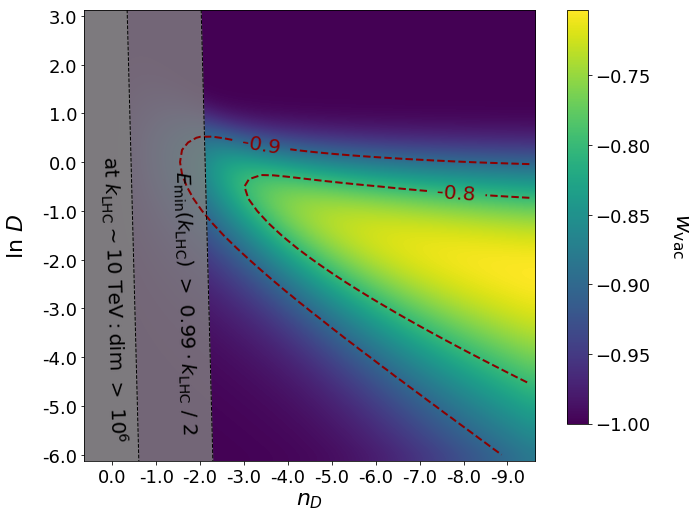

In [12]:
# reproducing Figure 2 of
# Friedrich, Singh, Dore (2022)

plt.figure(figsize=(10,7.2))

plt.imshow(w_values, interpolation='bicubic')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'$w_{\mathrm{vac}}$', size=22, rotation=270, labelpad=40)
plt.clim(-1.0,np.max(w_values))
cons = plt.contour(w_values, colors='darkred', linewidths=2, levels=[-0.9, -0.8, -0.5, 0.0])
plt.clabel(cons, fmt='%1.1f', fontsize=20, use_clabeltext=True)

# Formatting axes
ax = plt.gca()
indxs = np.arange(0, N_param-0.5, 1)
xvals = np.arange(-9.0, 0.1, 1.0)
yvals = np.arange(-6.0, 3.1, 1.0)
xts = np.interp(-xvals, -n_values, indxs)
yts = np.interp(yvals, logD_values, indxs)
ax.set_xticks(xts, minor=False)
ax.set_yticks(yts, minor=False)
x_strings = ["%.1f" % x for x in xvals]
y_strings = ["%.1f" % y for y in yvals]
ax.set_xticklabels(x_strings, size=18)
ax.set_yticklabels(y_strings, size=18)
ax.set_ylim(N_param-0.5, -0.5)
ax.set_xlim(-0.5, N_param-0.5)
ax.invert_yaxis()

# First boundary for consistency with low energy physics
# (dimension of IR modes should be high)
#
kLHC = 1.0e13/E_Planck_in_eV
xx = np.arange(-0.5, N_param-0.4, 0.1)
nn = n_min + xx/N_param*(n_max - n_min)
yy = np.log(1.0e6-2) - nn*np.log(kLHC/kUV)
yy = (yy-logD_min)/(logD_max-logD_min)*float(N_param) - 0.5
ax.fill_between(xx, 0.0*yy-1.0, yy, color="grey", alpha = 0.8)
ax.plot(xx, yy, color="black", linestyle='dashed', linewidth=1)

# Second boundary for consistency with low energy physics
# (vacuum energy of IR modes should be close to k_ph/2)
#
z = 12.0/np.pi**1.5*float(mpmath.erfinv(0.99))
yy = np.log((kUV/kLHC)**2*z-2) - nn*np.log(kLHC/kUV)
yy = (yy-logD_min)/(logD_max-logD_min)*float(N_param) - 0.5
ax.fill_between(xx, 0.0*yy-1.0, yy, color="grey", alpha = 0.8)
ax.plot(xx, yy, color="black", linestyle='dashed', linewidth=1)

plt.ylabel(r'$\ln\ D$', size=22, labelpad = 15)
plt.xlabel(r'$n_D$', size=22)

plt.text(0.5, 23, r"$\mathrm{at}\ k_{\mathrm{LHC}} \sim 10\ \mathrm{TeV}:  \mathrm{dim}\ >\ 10^6$", size=20, rotation=-88.5)
plt.text(6.5, 22, r"$E_{\mathrm{min}}(k_\mathrm{LHC})\ >\ 0.99 \cdot k_\mathrm{LHC}\ /\ 2$", size=20, rotation=-88.5)

plt.subplots_adjust(left = 0.10, bottom=0.10, top=0.97, right=0.93)
plt.savefig("w_as_function_of_dimensionality.pdf")

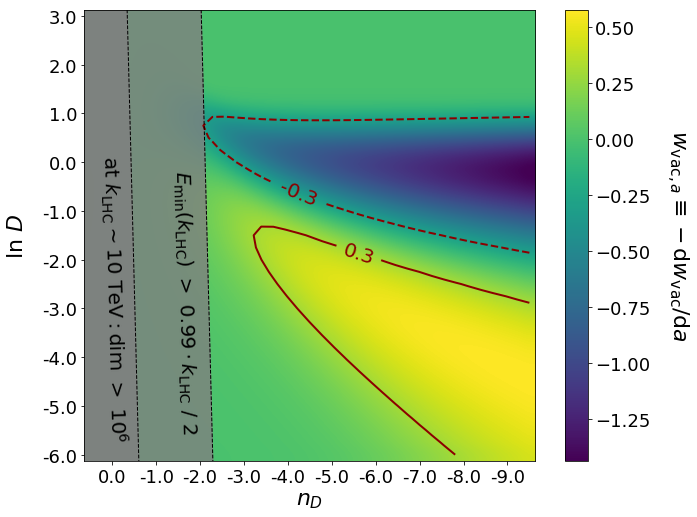

In [13]:
# Same as Figure 2 of Friedrich, Singh, Dore (2022)
# but for wa = -dw/da

plt.figure(figsize=(10,7.2))

plt.imshow(wa_values, interpolation='spline16')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'$w_{\mathrm{vac}, a} \equiv -\mathrm{d}w_{\mathrm{vac}}/\mathrm{d}a$', size=22, rotation=270, labelpad=40)
cons = plt.contour(wa_values, colors='darkred', linewidths=2, levels=[-0.3, 0.3])
plt.clabel(cons, fmt='%1.1f', fontsize=20, use_clabeltext=True)

# Formatting axes
ax = plt.gca()
indxs = np.arange(0, N_param-0.5, 1)
xvals = np.arange(-9.0, 0.1, 1.0)
yvals = np.arange(-6.0, 3.1, 1.0)
xts = np.interp(-xvals, -n_values, indxs)
yts = np.interp(yvals, logD_values, indxs)
ax.set_xticks(xts, minor=False)
ax.set_yticks(yts, minor=False)
x_strings = ["%.1f" % x for x in xvals]
y_strings = ["%.1f" % y for y in yvals]
ax.set_xticklabels(x_strings, size=18)
ax.set_yticklabels(y_strings, size=18)
ax.set_ylim(N_param-0.5, -0.5)
ax.set_xlim(-0.5, N_param-0.5)
ax.invert_yaxis()

# First boundary for consistency with low energy physics
# (dimension of IR modes should be high)
#
kLHC = 1.0e13/E_Planck_in_eV
xx = np.arange(-0.5, N_param-0.4, 0.1)
nn = n_min + xx/N_param*(n_max - n_min)
yy = np.log(1.0e6-2) - nn*np.log(kLHC/kUV)
yy = (yy-logD_min)/(logD_max-logD_min)*float(N_param) - 0.5
ax.fill_between(xx, 0.0*yy-1.0, yy, color="grey", alpha = 0.8)
ax.plot(xx, yy, color="black", linestyle='dashed', linewidth=1)

# Second boundary for consistency with low energy physics
# (vacuum energy of IR modes should be close to k_ph/2)
#
z = 12.0/np.pi**1.5*float(mpmath.erfinv(0.99))
yy = np.log((kUV/kLHC)**2*z-2) - nn*np.log(kLHC/kUV)
yy = (yy-logD_min)/(logD_max-logD_min)*float(N_param) - 0.5
ax.fill_between(xx, 0.0*yy-1.0, yy, color="grey", alpha = 0.8)
ax.plot(xx, yy, color="black", linestyle='dashed', linewidth=1)

plt.ylabel(r'$\ln\ D$', size=22, labelpad = 15)
plt.xlabel(r'$n_D$', size=22)

plt.text(0.5, 23, r"$\mathrm{at}\ k_{\mathrm{LHC}} \sim 10\ \mathrm{TeV}:  \mathrm{dim}\ >\ 10^6$", size=20, rotation=-88.5)
plt.text(6.5, 22, r"$E_{\mathrm{min}}(k_\mathrm{LHC})\ >\ 0.99 \cdot k_\mathrm{LHC}\ /\ 2$", size=20, rotation=-88.5)

plt.subplots_adjust(left = 0.10, bottom=0.10, top=0.97, right=0.93)
plt.savefig("wa_as_function_of_dimensionality.pdf")

In [14]:
# This function is calculating the vacuum energy density and
# its derivatives wrt. the radius of the observable Universe
# in the alternative scenario of Friedrich, Singh, Dore (2022).
# 
# This uses brute force trapezoidal quadrature, because mpmath integration routines
# can't handle the sharply peaked integrand appearing in our alternative construction.
# We have checked the accuracy of this procedure by comparing the resulting eps_vac
# and w_vac to analytical integration of the power law approximation of equation 4.9
# in Friedrich, Singh, Dore (2022).
#
#
def return_eps_vac_alternative_spacing(scale_factor, D, n_D, output_integrands=0):
    L_ph = scale_factor*L_c
    N_k = 5000
    k_min = 1.0/L_ph
    logk_min = mpmath.log(k_min)
    k_max = kUV
    logk_max = mpmath.log(k_max)
    dlogk = (logk_max - logk_min)/(N_k-1)
    logk_values = np.arange(float(logk_min), float(logk_max+0.5*dlogk), float(dlogk))
    #
    integrand_eps = []
    integrand_deps_da = []
    integrand_d2eps_da2 = []
    #
    # Simplifying the calculation:
    A = mpmath.pi**1.5/12.0
    two_over_sqrt_pi = 2.0/mpmath.sqrt(mpmath.pi)
    one_over_a = 1.0/scale_factor
    term0 = D*(scale_factor/kUV)**n_D
    #
    def f_all(lnk):
        k = mpmath.exp(lnk)
        omega = k*L_c
        Ak = A/omega
        term1 = term0*k**n_D
        Ck = Ak*(term1 + dmin)*one_over_a**3
        Dk = Ak*((n_D-3)*term1 - 3*dmin)*one_over_a**4
        k4 = k**4
        k4_exp = k4*mpmath.exp(-Ck**2)*two_over_sqrt_pi
        aa = k4*mpmath.erf(Ck)
        bb = k4_exp*Dk
        return aa, bb
    #
    for i in range(0, len(logk_values)):
        aa, bb = f_all(logk_values[i])
        integrand_eps.append(aa)
        integrand_deps_da.append(bb)
    #
    integrand_eps = np.array(integrand_eps)/(2.0*np.pi)**2
    #
    integrand_deps_da = np.array(integrand_deps_da)/(2.0*np.pi)**2
    #
    if output_integrands == 1:
        np.savetxt("integrands.dat", np.transpose([logk_values, integrand_eps, integrand_deps_da]))
    #
    return np.sum(integrand_eps[:-1]+integrand_eps[1:])*0.5*dlogk, np.sum(integrand_deps_da[:-1]+integrand_deps_da[1:])*0.5*dlogk

# This uses equations 3.3 and 3.10 of the draft to calculate the
# equation of state parameters of vacuum energy density:
#
def return_w_alternative_spacing(scale_factor, D, n_D, output_integrands=0):
    eps, deps_da = return_eps_vac_alternative_spacing(scale_factor, D, n_D, output_integrands)
    w0 = -(1.0+deps_da*scale_factor/eps/3.0)
    return eps, w0


In [15]:
# Same as return_eps_vac_alternative_spacing but using
# the power law approximation of equation 4.9 in
# Friedrich, Singh, Dore (2022).
# 
def return_eps_vac_power_law(scale_factor, D, n_D):
    # A == 2\pi/(12 * L_c)
    # B == e^y/k_UV^n_D
    # 
    # we have 
    # erf(...) = 1
    # for a^{n_D - 3} * k^{n_D - 1} >> 1/(AB)
    #
    # erf(...) = AB a^{n_D - 3} * k^{n_D - 1}
    # for a^{n_D - 3} * k^{n_D - 1} << 1/(AB)
    #
    # erf(...) = A a^{-3} * k^{-1}
    # for a^{n_D} k^{n_D} << d_min/B
    #
    # boundary 1: AB a^{n_D - 3} * k_1^{n_D - 1} != 1
    # => k_1 = (1/(AB)*a^{3-n_D})^{1/(n_D - 1)}
    #
    # boundary 2: dmin * a^{-3} * k_2^{-1} = B a^{n_D - 3} * k_2^{n_D - 1}
    # => dmin = B a^n_D k_2^n_D
    # => k_2 = (dmin/B)^{1/n_D}/a
    #
    # \int_0^{k_1} dk k^3 = 0.25 * k_1**4
    #
    # AB a^{n_D - 3} \int_{k_1}^{k_2} dk k^{n_D + 2}
    # = AB a^{n_D - 3} [k^{n_D + 3}/{n_D + 3}]_{k_1}^{k_2}
    #
    # dmin A a^{-3} \int_{k_2}^{k_UV} dk * k^2
    # = dmin A a^{-3} [k^3/3]_{k_2}^{k_UV}
    #
    # --> factor 1/(2\pi)^2 to all of that
    # 
    A = 2*mpmath.pi/(12.0 * L_c)
    B = D/kUV**n_D
    k_1 = (1.0/(A*B)*scale_factor**(3-n_D))**(1.0/(n_D - 1.0))
    if n_D != 0:
        k_2 = (dmin/B)**(1.0/n_D)/scale_factor
    else:
        k_2 = kUV
    if k_2 > kUV:
        k_2 = kUV
    result = 0.25 * k_1**4
    if n_D != -3.0:
        result += A*B*scale_factor**(n_D - 3)*(k_2**(n_D + 3.0)/(n_D + 3.0)-k_1**(n_D + 3.0)/(n_D + 3.0))
    else:
        result += A*B*scale_factor**(n_D - 3)*(mpmath.log(k_2)-mpmath.log(k_1))
    result += dmin*A/scale_factor**3*(kUV**3/3 - k_2**3/3)
    return result/(2.0*mpmath.pi)**2


def return_w_power_law(scale_factor, D, n_D):
    eps_1 = return_eps_vac_power_law(scale_factor*0.99, D, n_D)
    eps_2 = return_eps_vac_power_law(scale_factor*1.01, D, n_D)
    eps = 0.5*(eps_2 + eps_1)
    deps_da = (eps_2 - eps_1)/(0.02*scale_factor)
    w0 = -(1.0+deps_da*scale_factor/eps/3.0)
    return eps, w0
    

In [16]:
# computing data to reproduce Figure 3 of
# Friedrich, Singh, Dore (2022)

Lph_max = 1.0*L_c
Lph_min = 0.09*L_c
N = 50
dlogL = (np.log(Lph_max)-np.log(Lph_min))/float(N-1)
L_values = np.arange(np.log(Lph_min) , np.log(Lph_max) + 0.5*dlogL, dlogL)
L_values = np.exp(L_values)
#
eps_vals_1 = np.zeros(N)
eps_vals_2 = np.zeros(N)
eps_vals_3 = np.zeros(N)
#
eps_vals_alt_1 = np.zeros(N)
eps_vals_alt_2 = np.zeros(N)
eps_vals_alt_3 = np.zeros(N)


n_D = -5.0
logD = -3.5
D = mpmath.exp(logD)
for i in range(0,N):
    print("\r", int(10000.0*i/float(N))/100.0, "% of calculation done     ", end="")
    n_D = -5.0
    logD = -3.5
    D = mpmath.exp(logD)
    eps_vals_1[i], w_dummy, wa_dummy = return_w(L_values[i]/L_c, D, n_D)
    eps_vals_alt_1[i], w_dummy = return_w_alternative_spacing(L_values[i]/L_c, D, n_D)
    n_D = -4.0
    logD = -4.5
    D = mpmath.exp(logD)
    eps_vals_2[i], w_dummy, wa_dummy = return_w(L_values[i]/L_c, D, n_D)
    eps_vals_alt_2[i], w_dummy = return_w_alternative_spacing(L_values[i]/L_c, D, n_D)
    n_D = -3.0
    logD = -5.5
    D = mpmath.exp(logD)
    eps_vals_3[i], w_dummy, wa_dummy = return_w(L_values[i]/L_c, D, n_D)
    eps_vals_alt_3[i], w_dummy = return_w_alternative_spacing(L_values[i]/L_c, D, n_D)

print("\r100% of calculation done               ")

100% of calculation done               


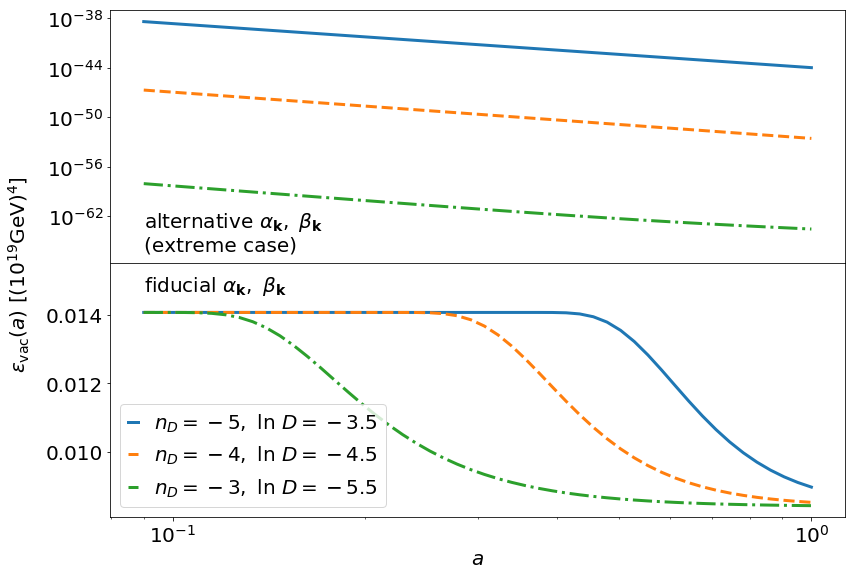

In [17]:
# reproducing Figure 3 of
# Friedrich, Singh, Dore (2022)

fig, axes = plt.subplots(nrows=2,  sharex=True, figsize=(12,8))
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[0].set_ylim(2.0e-68, 1.0e-37)
axes[1].set_ylim(0.0081, 0.0155)

Lph = R_hubble_prefactor/h

axes[1].semilogx(L_values/L_c, eps_vals_1*(E_Planck_in_eV*1.0e-9)**4/1.0e76, linewidth=3, linestyle='solid', label=r'$n_D = -5 ,\ \ln\ D = -3.5$')
axes[1].semilogx(L_values/L_c, eps_vals_2*(E_Planck_in_eV*1.0e-9)**4/1.0e76, linewidth=3, linestyle='dashed', label=r'$n_D = -4 ,\ \ln\ D = -4.5$')
axes[1].semilogx(L_values/L_c, eps_vals_3*(E_Planck_in_eV*1.0e-9)**4/1.0e76, linewidth=3, linestyle='-.', label=r'$n_D = -3 ,\ \ln\ D = -5.5$')
axes[1].set_xlabel(r"$a$", size=20)
axes[1].text(0.09, 0.0147, r"fiducial $\alpha_{\mathbf{k}},\ \beta_{\mathbf{k}}$", size=20)
axes[1].text(0.055, 0.0175, r"$\epsilon_{\mathrm{vac}}(a)$ [$(10^{19}$GeV$)^4$]", rotation=90, size=20)
axes[1].legend(fontsize=20, handlelength=0.5)

axes[0].loglog(L_values/L_c, eps_vals_alt_1, linewidth=3, linestyle='solid', label=r'$n_D = -3 ,\ \ln\ D = -0.5$')
axes[0].loglog(L_values/L_c, eps_vals_alt_2, linewidth=3, linestyle='dashed', label=r'$n_D = -2 ,\ \ln\ D = -0.5$')
axes[0].loglog(L_values/L_c, eps_vals_alt_3, linewidth=3, linestyle='-.', label=r'$n_D = -3 ,\ \ln\ D = -1.0$')
axes[0].set_xlabel(r"$a$", size=20)
axes[0].text(0.09, 1.0e-66, r"alternative $\alpha_{\mathbf{k}},\ \beta_{\mathbf{k}}$"+"\n(extreme case)", size=20)


plt.subplots_adjust(left=0.13, bottom=0.10, top=0.98, right=0.98, hspace=0.0)
plt.savefig("eps_vs_a.pdf")

In [18]:
# calculating data to reproduce Figures 5 and 7
# of Friedrich, Singh, Dore (2022)

n_D = -3.5
logD = -4.0

a1 = 1.0
a2 = 0.8
a3 = 0.5

return_w_alternative_spacing(a1, mpmath.exp(logD), n_D, 1)
data_1 = np.loadtxt("integrands.dat")

return_w_alternative_spacing(a2, mpmath.exp(logD), n_D, 1)
data_2 = np.loadtxt("integrands.dat")

return_w_alternative_spacing(a3, mpmath.exp(logD), n_D, 1)
data_3 = np.loadtxt("integrands.dat")

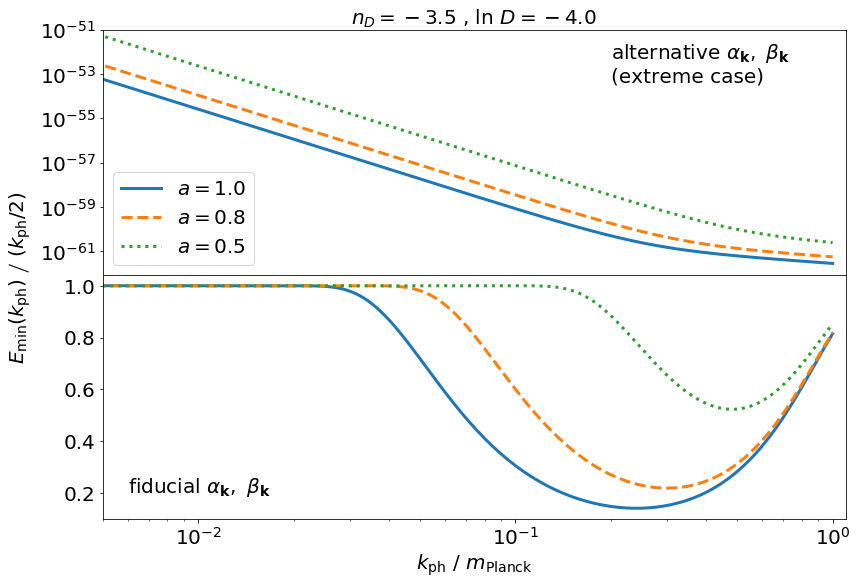

In [19]:
# reproducing Figure 5 of
# Friedrich, Singh, Dore (2022)

k_values = np.exp(data_1[:,0])

integrand_alternative_1 = data_1[:,1]
integrand_alternative_2 = data_2[:,1]
integrand_alternative_3 = data_3[:,1]
integrand_fiducial_1 = scipy.special.erf(np.pi**1.5/12.0*(k_values/kUV)**2*(np.exp(logD)*(a1*k_values/kUV)**n_D+dmin))
integrand_fiducial_2 = scipy.special.erf(np.pi**1.5/12.0*(k_values/kUV)**2*(np.exp(logD)*(a2*k_values/kUV)**n_D+dmin))
integrand_fiducial_3 = scipy.special.erf(np.pi**1.5/12.0*(k_values/kUV)**2*(np.exp(logD)*(a3*k_values/kUV)**n_D+dmin))

fig, axes = plt.subplots(nrows=2,  sharex=True, figsize=(12,8))
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

axes[1].semilogx(k_values, integrand_fiducial_1, linewidth=3, linestyle='solid')
axes[1].semilogx(k_values, integrand_fiducial_2, linewidth=3, linestyle='dashed')
axes[1].semilogx(k_values, integrand_fiducial_3, linewidth=3, linestyle='dotted')
axes[1].set_xlabel(r"$k_{\mathrm{ph}}\ /\ m_{\mathrm{Planck}}$", size=20)
axes[1].set_xlim(5.0e-3, 1.1)
axes[1].text(6.0e-3, 0.2, r"fiducial $\alpha_{\mathbf{k}},\ \beta_{\mathbf{k}}$", size=20)
axes[1].text(2.5e-3, 1.3, r"$\left.E_{\mathrm{min}}(k_{\mathrm{ph}})\ \right/\ (k_{\mathrm{ph}}/2)$", rotation=90, size=20)

axes[0].loglog(k_values, integrand_alternative_1/k_values**4*(2.0*np.pi)**2, linewidth=3, linestyle='solid', label=r'$a = 1.0$')
axes[0].loglog(k_values, integrand_alternative_2/k_values**4*(2.0*np.pi)**2, linewidth=3, linestyle='dashed', label=r'$a = 0.8$')
axes[0].loglog(k_values, integrand_alternative_3/k_values**4*(2.0*np.pi)**2, linewidth=3, linestyle='dotted', label=r'$a = 0.5$')
axes[0].set_xlim(5.0e-3, 1.1)
axes[0].set_ylim(9.0e-63, 1.0e-51)
axes[0].legend(fontsize=20, loc='lower left')
axes[0].text(2.0e-1, 5.0e-54, r"alternative $\alpha_{\mathbf{k}},\ \beta_{\mathbf{k}}$"+"\n(extreme case)", size=20)

axes[0].set_title(r"$n_D = -3.5$ , $\ln\ D = -4.0$", size=20)

plt.subplots_adjust(left=0.12, bottom=0.10, top=0.95, right=0.98, hspace=0.0)
plt.savefig("integrands.pdf")


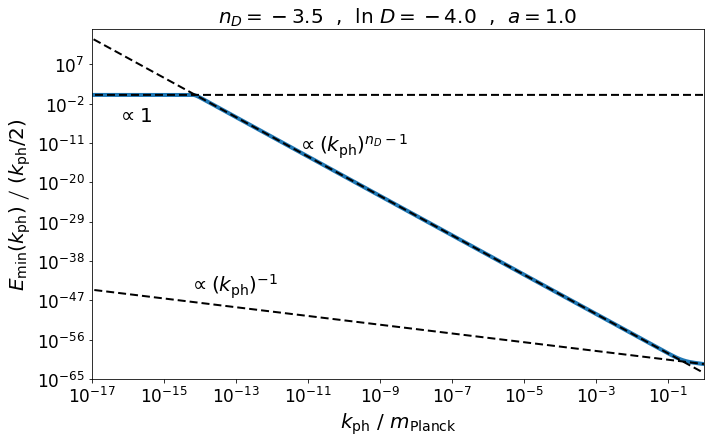

In [20]:
# reproducing Figure 7 of
# Friedrich, Singh, Dore (2022)

plt.figure(figsize=(10,6))
plt.xticks(size=17)
plt.yticks(size=17)

yy = integrand_alternative_1/k_values**4*(2.0*np.pi)**2
plt.loglog(k_values, yy, linewidth=4, linestyle='solid', color='tab:blue', label=r'$a = 1.0$')

plt.plot(k_values, 1.0+0.0*k_values, linestyle='dashed', dashes=(4, 2), color='black', linewidth=2)
indx = np.argmin((k_values-1.0e-9)**2)
plt.plot(k_values, (k_values/k_values[indx])**(-3.5-1)*yy[indx], linestyle='dashed', dashes=(4, 2), color='black', linewidth=2)
indx = len(k_values)-1
plt.plot(k_values, (k_values/k_values[indx])**(-1)*yy[indx], linestyle='dashed', dashes=(4, 2), color='black', linewidth=2)

plt.xlim(1.0e-17, 1.0)
plt.ylim(1.0e-65, 1.0e15)
plt.xlabel(r"$k_{\mathrm{ph}}\ /\ m_{\mathrm{Planck}}$", size=20)
plt.ylabel(r"$\left.E_{\mathrm{min}}(k_{\mathrm{ph}})\ \right/\ (k_{\mathrm{ph}}/2)$", size=20)
plt.title(r"$n_D = -3.5$  ,  $\ln\ D = -4.0$  ,  $a = 1.0$", size=20)

plt.text(5.0e-17, 1.0e-6, r"$\propto 1$", size = 20)
plt.text(5.0e-12, 1.0e-13, r"$\propto (k_{\mathrm{ph}})^{n_D - 1}$", size = 20)
plt.text(5.0e-15, 1.0e-45, r"$\propto (k_{\mathrm{ph}})^{- 1}$", size = 20)

plt.subplots_adjust(left=0.13, bottom=0.12, top = 0.93, right = 0.98)
plt.savefig("Integrant_alternative_case_asymptotes.pdf")


In [21]:
# calculating data to reproduce Figure 4
# of Friedrich, Singh, Dore (2022)
#
# WARNING: This calculation takes very long! A faster
# C++ version of the calculation will be available soon.
# Alternatively, you can replace return_w_alternative_spacing
# by return_w_power_law.
#

N_param = 37

n_min = 0.5
n_max = -9.5
dn = (n_max-n_min)/(N_param-1)

logD_min = -6.0
logD_max = 3.0
dlogD = (logD_max-logD_min)/(N_param-1)

n_values = np.arange(n_min, n_max + 0.5*dn, dn)
logD_values = np.arange(logD_min, logD_max + 0.5*dlogD, dlogD)

eps_values_alt = np.zeros((N_param, N_param))
w_values_alt = np.zeros((N_param, N_param))

for j in range(0, N_param):
    n_D = n_values[j]
    for i in range(0, N_param):
        print("\r", int(10000.0*(j*N_param+i)/float(N_param**2))/100.0, "% of calculation done     ", end="")
        logD = logD_values[i]
        eps_values_alt[i,j], w_values_alt[i,j] = return_w_alternative_spacing(1.0, mpmath.exp(logD), n_D)
        #eps_values_alt[i,j], w_values_alt[i,j] = return_w_power_law(1.0, mpmath.exp(logD), n_D)

print("\r100% of calculation done               ")

100% of calculation done               


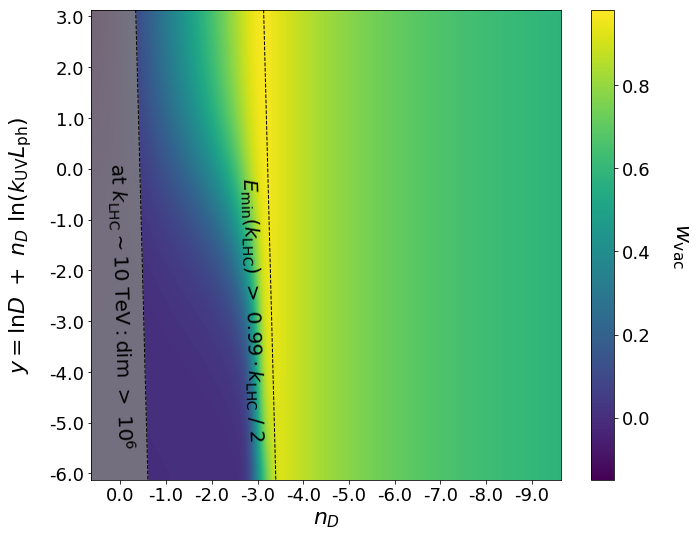

In [22]:
plt.figure(figsize=(10,7.5))

plt.imshow(w_values_alt, interpolation='bicubic')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'$w_{\mathrm{vac}}$', size=22, rotation=270, labelpad=40)

# Formatting axes
ax = plt.gca()
indxs = np.arange(0, N_param-0.5, 1)
xvals = np.arange(-9.0, 0.1, 1.0)
yvals = np.arange(-6.0, 3.1, 1.0)
xts = np.interp(-xvals, -n_values, indxs)
yts = np.interp(yvals, logD_values, indxs)
ax.set_xticks(xts, minor=False)
ax.set_yticks(yts, minor=False)
x_strings = ["%.1f" % x for x in xvals]
y_strings = ["%.1f" % y for y in yvals]
ax.set_xticklabels(x_strings, size=18)
ax.set_yticklabels(y_strings, size=18)
ax.set_ylim(N_param-0.5, -0.5)
ax.set_xlim(-0.5, N_param-0.5)
ax.invert_yaxis()


# First boundary for consistency with low energy physics
# (dimension of IR modes should be high)
#
kLHC = 1.0e13/E_Planck_in_eV
xx = np.arange(-0.5, N_param-0.4, 0.1)
nn = n_min + xx/N_param*(n_max - n_min)
yy = np.log(1.0e6-2) - nn*np.log(kLHC/kUV)
yy = (yy-logD_min)/(logD_max-logD_min)*float(N_param) - 0.5
ax.fill_between(xx, 0.0*yy-1.0, yy, color="grey", alpha = 0.8)
ax.plot(xx, yy, color="black", linestyle='dashed', linewidth=1)

# Second boundary for consistency with low energy physics
# (vacuum energy of IR modes should be close to k_ph/2)
#
z = 12.0/np.pi**1.5*float(mpmath.erfinv(0.99))
yy = np.log(kLHC*L_c*z-2) - nn*np.log(kLHC/kUV)
yy = (yy-logD_min)/(logD_max-logD_min)*float(N_param) - 0.5
ax.plot(xx, yy, color="black", linestyle='dashed', linewidth=1)


plt.ylabel(r'$y = \ln D\ +\ n_D\ \ln(k_{\mathrm{UV}}L_{\mathrm{ph}})$', size=22, labelpad = 15)
plt.xlabel(r'$n_D$', size=22)

plt.text(0.5, 23, r"$\mathrm{at}\ k_{\mathrm{LHC}} \sim 10\ \mathrm{TeV}:  \mathrm{dim}\ >\ 10^6$", size=20, rotation=-88.5)
plt.text(11, 22, r"$E_{\mathrm{min}}(k_\mathrm{LHC})\ >\ 0.99 \cdot k_\mathrm{LHC}\ /\ 2$", size=20, rotation=-88.5)

plt.subplots_adjust(left = 0.10, bottom=0.10, top=0.97, right=0.93)
plt.savefig("w_vs_dimensionality_alternative_spacing.pdf")